In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Data structure to encapuslate information
class Value:
    #the value of the number, from whom it is created and what operation created it
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, o): # self + other
        o = o if isinstance(o, Value) else Value(o)
        out = Value(self.data + o.data, (self, o), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            o.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
        
    def __mul__(self, o): # self * other
        o = o if isinstance(o, Value) else Value(o)
        out = Value(self.data * o.data, (self, o), '*')

        def _backward():
            self.grad += o.data * out.grad
            o.grad += self.data * out.grad
        out._backward = _backward
        
        return out


    def __pow__(self, o): # self ** other
        assert isinstance(o, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**o, (self, ), f'**{o}')

        def _backward():
            self.grad += o * (self.data ** (o - 1)) * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, o): # other ** self
        return self * o

    def __truediv__(self,o): # self / other
        return self * o**-1

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self,o): # self - other
        return self + (-o)


    def __radd__(self,o): # other + self
        return self + o
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [8]:
a = Value(2.0)
a.exp()
a

Value(data=2.0)

In [9]:
from graphviz import Digraph
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set() , set()
    def build(v):
        if v not in v._prev:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any node in graph create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is the result of some operation, create an op node for it
            dot.node(name= uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid+ n._op, uid)
    for n1, n2 in edges:
        # connect n1 to op nodes of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

    

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

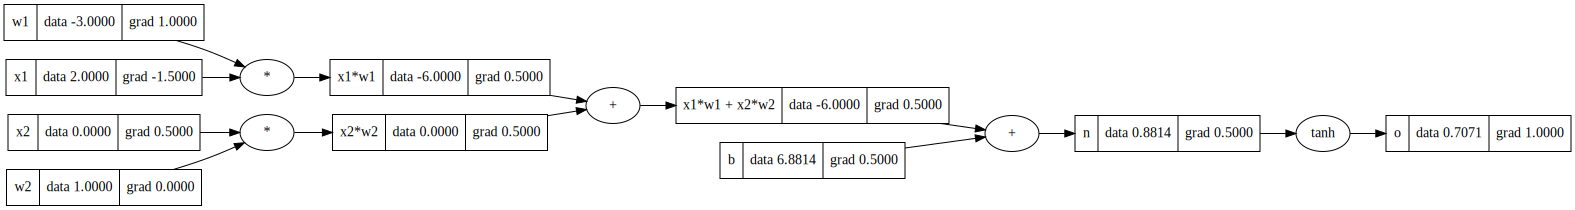

In [11]:
draw_dot(o)

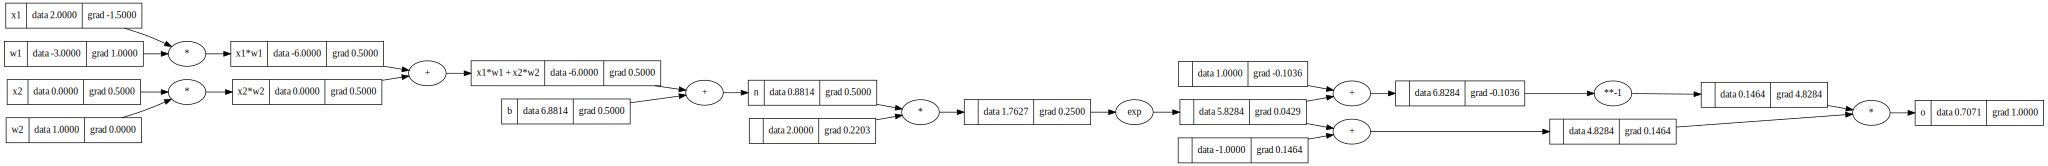

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [13]:
# same thing but in torch 

import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [14]:

class Neuron:
    def __init__(self, nin): #nin= number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w = x + b
        act = sum((wi*xi for wi, xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP: #multi layer perceptron
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [15]:
x = [2.0,3.0, -1]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.342158152583185)

In [16]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]]
ys = [1.0,-1.0,-1.0,1.0]

In [17]:
for k in range(200):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys,ypred)])
    #zero grad
    for p in n.parameters():
        p.grad = 0.0
        
    # backward pass
    loss.backward()
    #updaate
    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)

0 4.2249895620750735
1 3.8698933042604167
2 5.46846715497787
3 0.2818309707354348
4 0.12289679342459311
5 0.08814162276048634
6 0.06942180349012524
7 0.05719985386370571
8 0.048549567737782864
9 0.042106243779503276
10 0.03712586934946926
11 0.03316510834323008
12 0.029942887366134343
13 0.02727236459550078
14 0.025024540433551623
15 0.023107526264316655
16 0.021454127533769463
17 0.020014093818277342
18 0.018749110789062506
19 0.0176294661700453
20 0.016631771969181374
21 0.015737372599751952
22 0.01493120975660215
23 0.01420099833902354
24 0.013536618470527327
25 0.012929660373656355
26 0.012373079138928217
27 0.01186092967845042
28 0.011388160982133109
29 0.010950454779232278
30 0.010544097831516103
31 0.010165879967918427
32 0.009813012014764446
33 0.009483059243293382
34 0.009173887022340458
35 0.008883616147028912
36 0.008610585895259058
37 0.008353323298940812
38 0.008110517445808893
39 0.007880997878335644
40 0.007663716348833919
41 0.007457731338897431
42 0.007262194867507605


In [226]:
ypred

[Value(data=0.9916554794444595),
 Value(data=-0.994225349608277),
 Value(data=-0.9887299679123139),
 Value(data=0.9876680556768254)]

In [ ]:
# End of lecture
# Learnings from the lecture
# How gradient descent works
# How to use the gradient to update the parameters
# Converging to a solution with gradient descent

# As long as i know the derivative of a function
# I can apply gradient descent